# Определение закономерностей успешности компьютерных игр

**Описание проекта**

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Цель исследования**

Необходимо выявить закономерности успешности игры, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. В ходе исследования проверим следующие гипотезы:

 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
 - средние пользовательские рейтинги жанров Action и Sports разные.

**Ход исследования**

Наше исследование будет включать следующие этапы:

 - Обзор данных
 - Предобработка данных
 - Исследовательский анализ данных
 - Проверка гипотез

## Обзор данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

In [2]:
# Сохраним данные из файла в переменной df
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Получим общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Согласно документации:

 - `Name` — название игры
 - `Platform` — платформа
 - `Year_of_Release` — год выпуска
 - `Genre` — жанр игры
 - `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
 - `EU_sales` — продажи в Европе (миллионы проданных копий)
 - `JP_sales` — продажи в Японии (миллионы проданных копий)
 - `Other_sales` — продажи в других странах (миллионы проданных копий)
 - `Critic_Score` — оценка критиков (максимум 100)
 - `User_Score` — оценка пользователей (максимум 10)
 - `Rating` — рейтинг от организации ESRB

**Выводы:** 

В ходе первичного рассмотрения данных можно сделать следующие выводы:

1) Столбцы в таблице названы стилистически некорректно, верно, когда наименование написано в нижнем регистре.

2) Всего в датасете 16 715 строк, но данные не по всем столбцам заполнены полностью - есть пропуски.

3) В столбцах `Year_of_Release` и `User_Score` неверный тип данных.

## Предобработка данных  <a id="preprocessing"></a>

### Стиль заголовков

In [4]:
# Изменим наименование столбцов (приведем их к нижнему регистру)
df.columns = df.columns.str.lower()

In [5]:
# Проверка
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

In [6]:
# Посчитаем % пропусков по столбцам
round(df.isna().mean()*100,2)

name                0.01
platform            0.00
year_of_release     1.61
genre               0.01
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
critic_score       51.32
user_score         40.09
rating             40.48
dtype: float64

Всего пропуски обнаружены в 6 столбцах, в 3-х из них (`name`,`year_of_release`,`genre`) % пропусков совсем незначительный, поэтому можем просто удалить эти строки. В 3-х других (`critic_score`, `user_score`, `rating`) процент пропусков от 40% до 50%, возможная причина их наличия в том, что по этим играм действительно нет оценок пользователей, критиков и рейтинга ESRB. Заменим пропуски по столбцу `rating` на unknown, а пропуски по столбцам с оценками оставим без изменений.

In [7]:
# Удалим строки, где % пропусков незначительный
df = df.dropna(subset=['name', 'year_of_release','genre'])

In [8]:
# Заполним пропуски по столбцу rating
df['rating'] = df['rating'].fillna('unknown')

In [9]:
# Проверка
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

В столбце user_score присутствует аббревиатура 'tbd', в сфере компьютерных игр она расшифровывается как to be determined (будет определено) и означает, что игра готовится к выходу, но разработчики пока не могут озвучить точную дату.

In [10]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [11]:
# В данном случае заменим эти значения на 0, так как оценки от пользователей пока нет.
df['user_score'] = df['user_score'].replace('tbd', 0)

### Изменение типов данных

In [12]:
# Информация в столбце year_of_release - год выпуска игры, более корректно, если данные будут иметь формат int
df['year_of_release'] = df['year_of_release'].astype(int)

In [13]:
# Тип данных в столбце user_score изменим на float аналогично данным в столбце critic_score 
df['user_score'] = df['user_score'].astype(float)

In [14]:
# Проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Проверка данных на дубликаты

In [15]:
df.duplicated().sum()

0

Явных дубликатов нет.

Проверим неявные дубликаты по столбцам `name`,`platform` и `genre`

In [16]:
df['name'].sort_values().unique()

array([' Beyblade Burst', ' Fire Emblem Fates', " Frozen: Olaf's Quest",
       ..., 'uDraw Studio', 'uDraw Studio: Instant Artist',
       '¡Shin Chan Flipa en colores!'], dtype=object)

In [17]:
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [18]:
df['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

Неявных дубликатов тоже нет.

### Проверка данных на аномалии

In [19]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,7983.000000,9839.000000
mean,2006.486256,0.264012,0.145930,0.078487,0.047594,68.994363,5.405407
std,5.875525,0.818378,0.506716,0.311100,0.188005,13.920060,3.317917
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,2.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,6.900000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Аномалий в данных нет, но в столбцах с продажами наблюдается большая разница между максимальным значениями и основной массой данных, вероятно, есть очень много непопулярных игр и небольшая часть наоборот наиболее распространенных. 

### Дополнительные расчёты

Рассчитаем суммарные продажи во всех регионах

In [20]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


**Выводы:**

В ходе этапа предобработки данных мы:
- исправили наименования столбцов, 
- привели данные к нужным типам, 
- заполнили пропуски, 
- проверили, что в данных нет дубликатов и аномалий
- для дальнейшего анализа рассчитали суммарные продажи во всех регионах.

## Исследовательский анализ данных

### Количество игр выпускаемых в год

Посмотрим, сколько компьютерных игр выпускалось в разные годы.

In [21]:
# Посчитаем количество
games_by_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
games_by_year.columns = ['year', 'count_games']
games_by_year

,year,count_games
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


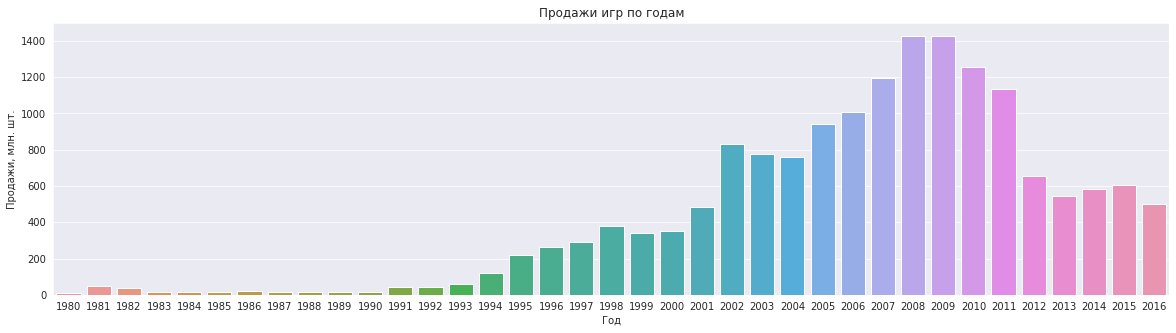

In [22]:
# Построим график
sns.set_style('darkgrid')
plt.figure(figsize=(20, 5))
sns.countplot(data = df, x='year_of_release')
plt.title('Продажи игр по годам')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Год');

На графике видно, что количество выпускаемых игр значительно растет с 2002 года, пик приходится на 2008-2009 год, а с 2012 г. количество выпускаемых игр значительно сокращается.

### Продажи по платформам

Выберем платформы с наибольшими суммарными продажами.

In [23]:
# Найдём суммарные продажи по каждой платформе
platform_sales = df.groupby(['platform'])['total_sales'].sum().reset_index().sort_values(by = 'total_sales', ascending=False)
# Выведем статистики 
platform_sales.describe()

,total_sales
count,31.000000
mean,284.334516
std,343.954144
min,0.030000
25%,22.150000
50%,200.040000
75%,301.205000
max,1233.560000


In [24]:
# Платформы с наибольшими продажами находятся в 4-м квартиле, отфильтруем данные
platform_sales = platform_sales.query('total_sales >= 301.20').reset_index()
platform_sales

,index,platform,total_sales
0,16,PS2,1233.56
1,28,X360,961.24
2,17,PS3,931.34
3,26,Wii,891.18
4,4,DS,802.78
5,15,PS,727.58
6,18,PS4,314.14
7,6,GBA,312.88


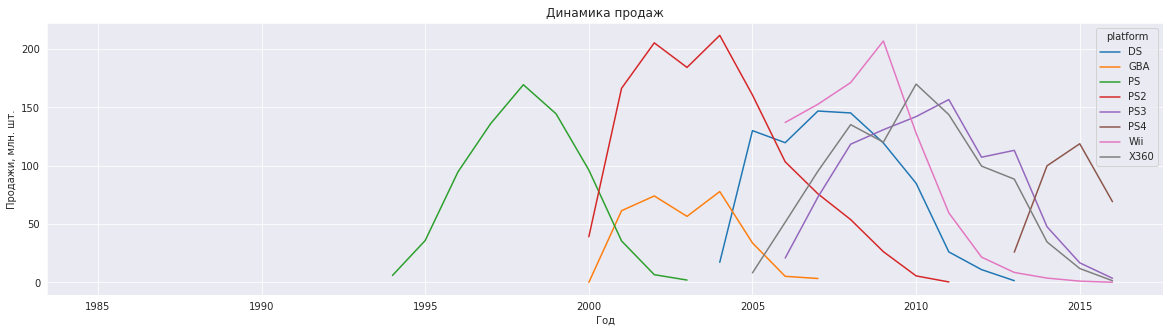

In [25]:
# Построим график суммарных продаж по популярным платформам в динамике
platform_sales = list(platform_sales['platform'])
platform_sales_by_year = df.query('platform.isin(@platform_sales)').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
platform_sales_by_year.plot(figsize=(20, 5))
plt.title('Динамика продаж')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Год');
plt.show()

На графике отчетливо прослеживается жизненный цикл игровых платформ - примерно 10 лет, после на смену приходят более совершенные консоли. 

### Выбор актуального периода

Для прогнозирования продаж на следующий год обычно не берут данные более чем за 2-3 года, а в случае динамично развивающийся индустрии такой, например, как компьютерные игры точно не нужно выбирать большой интервал, поэтому для целей нашего исследования ограничимся данными за 2015-2016 г.

In [26]:
analysis_period = df[(df['year_of_release'] >= 2015)]
analysis_period.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,7.39


### Выбор потенциально прибыльных платформ

Проанализируем, какие платформы занимают лидирующие позиции по продажам, растут ли продажи со временем или падают. Определим несколько потенциально прибыльных платформ.

In [27]:
top_platform = df.query('year_of_release >= 2005').pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum')
top_platform

platform,3DS,DC,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,
2005,NaN,NaN,130.14,33.86,27.62,4.37,160.66,NaN,NaN,43.84,NaN,NaN,NaN,8.25,49.08,NaN
2006,NaN,NaN,119.81,5.28,11.26,2.85,103.42,20.96,NaN,55.32,NaN,137.15,NaN,51.62,10.04,NaN
2007,NaN,0.02,146.94,3.40,0.27,9.28,75.99,73.19,NaN,46.93,NaN,152.77,NaN,95.41,0.55,NaN
2008,NaN,0.04,145.31,NaN,NaN,12.42,53.90,118.52,NaN,34.55,NaN,171.32,NaN,135.26,0.18,NaN
2009,NaN,NaN,119.54,NaN,NaN,16.91,26.40,130.93,NaN,37.78,NaN,206.97,NaN,120.29,NaN,NaN
2010,NaN,NaN,85.02,NaN,NaN,24.28,5.64,142.17,NaN,35.04,NaN,127.95,NaN,170.03,NaN,NaN
2011,63.20,NaN,26.18,NaN,NaN,35.03,0.45,156.78,NaN,17.82,4.63,59.65,NaN,143.84,NaN,NaN
2012,51.36,NaN,11.01,NaN,NaN,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN,NaN
2013,56.57,NaN,1.54,NaN,NaN,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,NaN,18.96


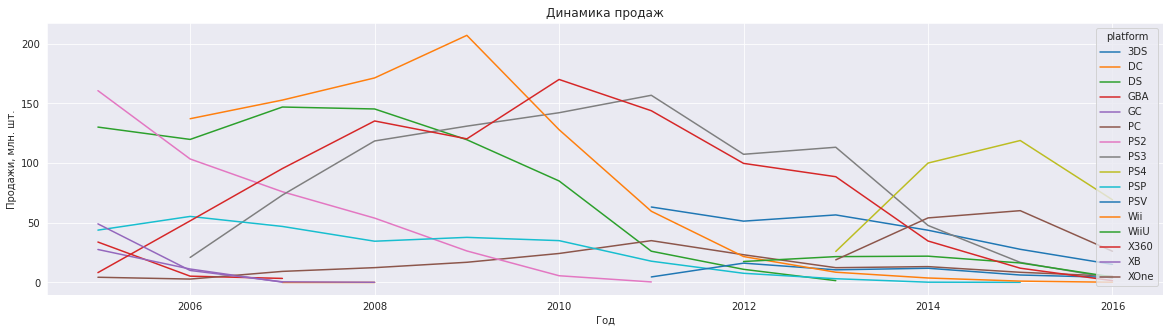

In [28]:
top_platform.plot(figsize=(20, 5))
plt.ylabel('total_sales')
plt.legend(title='platform',loc='upper right')
plt.title('Динамика продаж')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Год');
plt.show()

По графику можно сделать следующие выводы:
 - тенденция роста продаж есть только у 2-х игровых платформ - PS4 и XOne 
 - высокие продажи продолжительное время наблюдаются у X360 и PS3
 - в последние годы стабильные продажи наблюдаются также у 3DS
 - продажи по другим платформам в последние 5 лет (2011 - 2016 г.) либо значительно сокращаются, либо уже достигли 0, что означает, что платформа ушла с рынка.
 
Таким образом, для дальнейшего анализа будем использовать данные только по 5-ти игровым консолям: PS4, XOne, X360, PS3, 3DS

In [29]:
top_platform = df.loc[df['platform'].isin(('PS4', 'XOne', 'X360', 'PS3', '3DS'))]
top_platform.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63


### Продажи по самым прибыльным платформам

Построим график «ящик с усами».

Text(0.5, 0, 'Платформа')

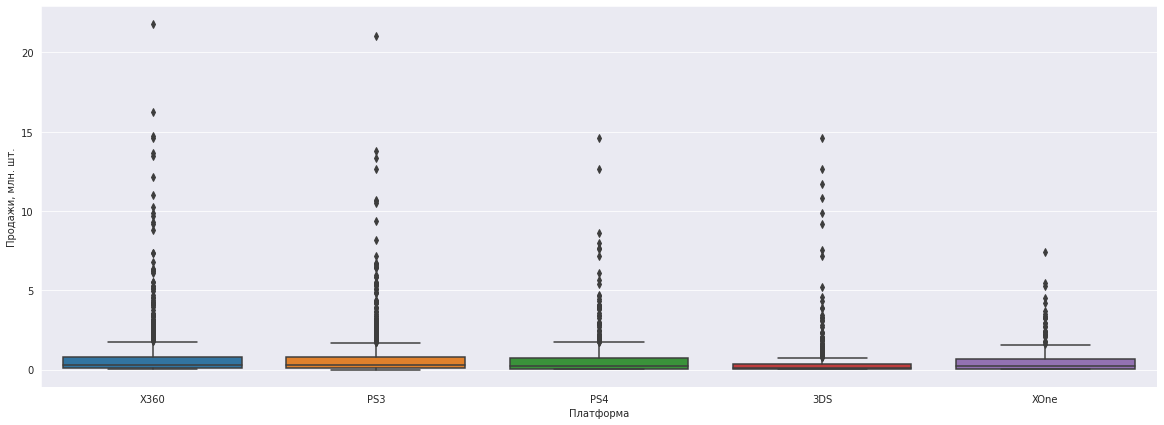

In [30]:
plt.figure(figsize=(20,7))
sns.boxplot(data = top_platform, x='platform', y='total_sales')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Платформа')

В данных есть выбросы, но основная часть продаж сосредоточена в промежутке примерно от 0 до 1 млн. копий, ограничим наш график для большей наглядности.

Text(0.5, 0, 'Платформа')

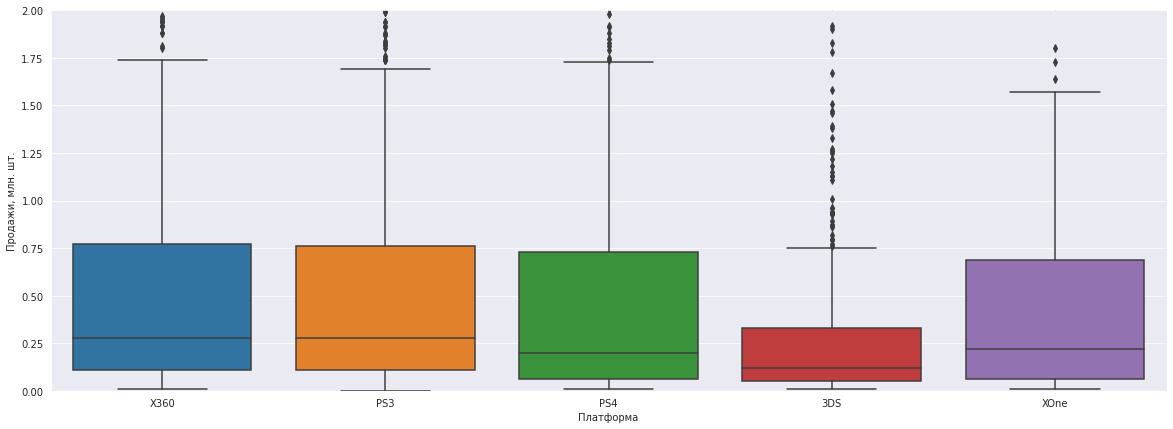

In [31]:
plt.figure(figsize=(20,7))
plt.ylim([0,2])
sns.boxplot(data = top_platform, x='platform', y='total_sales')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Платформа')

По графику видно, что медиана у X360, PS3, PS4 и XOne находится практически на одном уровне, у 3DS она меньше. Больше всего продаж за данный период у PS4 и XOne, эти же 2 консоли обладают наибольшим потенциалом роста.

### Влияние оценок пользователей и критиков на продажи XOne

Рассмотрим влияние оценок пользователей и критиков на продажи по платформе XOne.

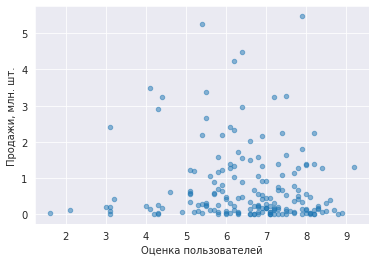

In [32]:
# Оценим влияние пользовательских оценок
XOne_user_score = df.query('user_score != 0 & platform == "XOne"')
XOne_user_score.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5)
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Оценка пользователей')
plt.show()

In [33]:
XOne_user_score['user_score'].corr(XOne_user_score['total_sales']).round(2)

-0.07

Оценка пользователей не влияет на продажи.

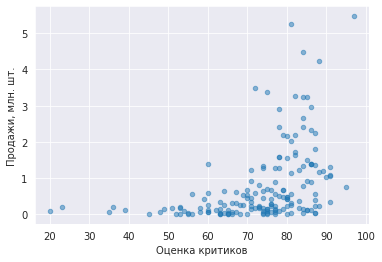

In [34]:
# Оценим влияние оценок критиков
XOne_critic_score = df.query('critic_score != 0 & platform == "XOne"')
XOne_critic_score.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5)
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Оценка критиков')
plt.show()

In [35]:
XOne_critic_score['critic_score'].corr(XOne_critic_score['total_sales']).round(2)

0.42

Продажи XOne в средней степени зависят от оценки критиков, зависимость прямая: чем выше оценка, тем больше продажи.

### Влияние оценок пользователей и критиков на продажи по другим платформам

Платформа PS3:
Коэффициент корреляции: 0.13
Платформа PS4:
Коэффициент корреляции: -0.03
Платформа X360:
Коэффициент корреляции: 0.11
Платформа 3DS:
Коэффициент корреляции: 0.22


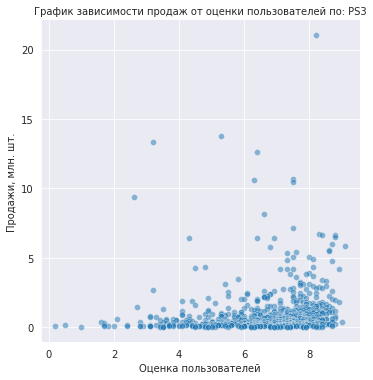

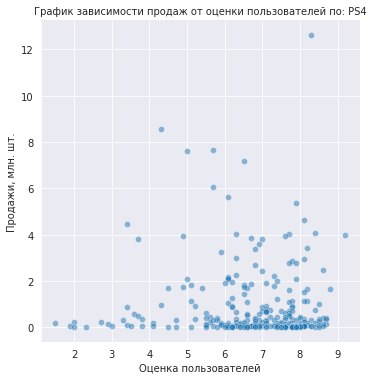

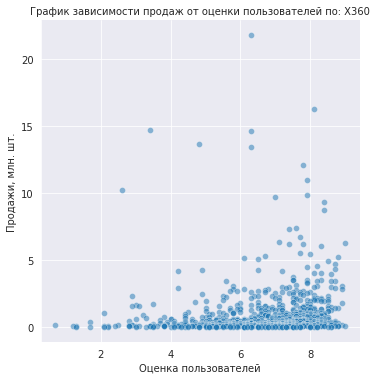

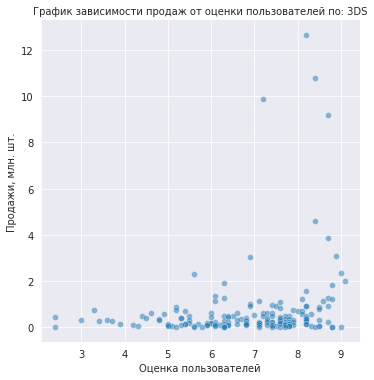

In [36]:
# Автоматизируем процесс построения графиков по пользовательским оценкам 
for platform in ['PS3', 'PS4', 'X360', '3DS']:
    print('Платформа {0}:'.format(platform))
    for column in ['user_score']:
        filtered_data = df.query('platform == @platform and (user_score != 0)')
        sns.relplot(x=column, y='total_sales', data=filtered_data, alpha = 0.5)
        print('Коэффициент корреляции: {1}'.format(column, round(filtered_data[column].corr(filtered_data['total_sales']), 2)))
        plt.title('График зависимости продаж от оценки пользователей по: '+ platform, fontsize= 10)
        plt.ylabel('Продажи, млн. шт.')
        plt.xlabel('Оценка пользователей')

Платформа PS3:
Коэффициент корреляции: 0.43
Платформа PS4:
Коэффициент корреляции: 0.41
Платформа X360:
Коэффициент корреляции: 0.39
Платформа 3DS:
Коэффициент корреляции: 0.35


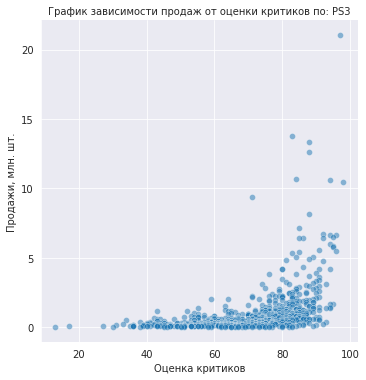

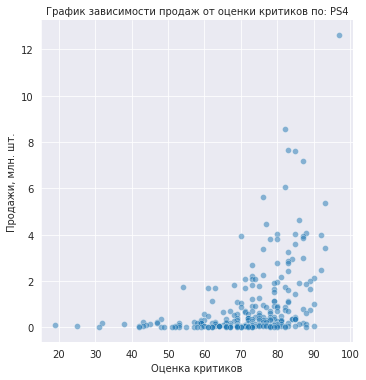

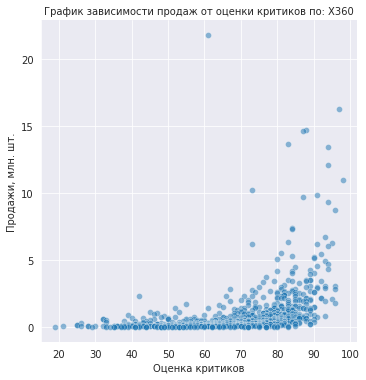

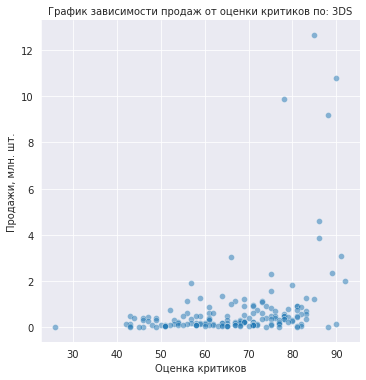

In [37]:
# Автоматизируем процесс построения графиков по оценкам от критиков 
for platform in ['PS3', 'PS4', 'X360', '3DS']:
    print('Платформа {0}:'.format(platform))
    for column in ['critic_score']:
        filtered_data = df.query('platform == @platform and (critic_score != 0)')
        sns.relplot(x=column, y='total_sales', data=filtered_data, alpha = 0.5)
        print('Коэффициент корреляции: {1}'.format(column, round(filtered_data[column].corr(filtered_data['total_sales']), 2)))
        plt.title('График зависимости продаж от оценки критиков по: '+ platform, fontsize= 10)
        plt.ylabel('Продажи, млн. шт.')
        plt.xlabel('Оценка критиков')

На основании графиков и коэффициентов корреляции можно сделать следующие выводы:

- оценки пользователей не влияют на продажи платформ;
- оценки критиков влияют на продажи платформ в незначительной степени, коэффициенты корреляции свидетельствуют о наличии прямой и слабой связи.

### Распределение игр по жанрам

Построим график распределения игр по жанрам

In [38]:
# Посчитаем суммарные продажи в разрезе жанров
genre_pivot = analysis_period.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()
genre_pivot

,genre,total_sales
0,Shooter,105.73
1,Action,102.13
2,Sports,64.33
3,Role-Playing,55.82
4,Misc,14.17
5,Fighting,12.37
6,Adventure,11.98
7,Racing,10.86
8,Platform,9.28
9,Simulation,7.55


Text(0.5, 0, 'Жанр')

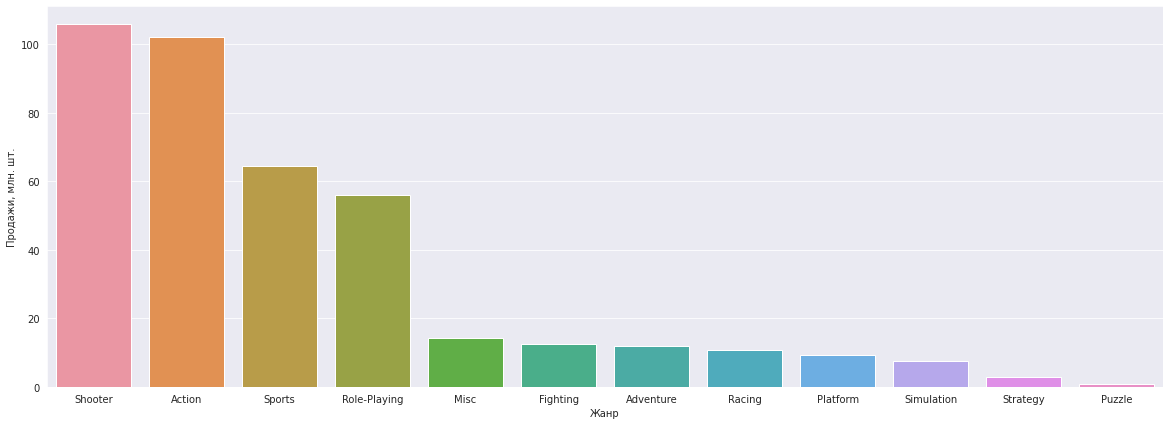

In [39]:
plt.figure(figsize=(20,7))
sns.barplot(data = genre_pivot, x='genre', y='total_sales')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Жанр')

Text(0.5, 0, 'Жанр')

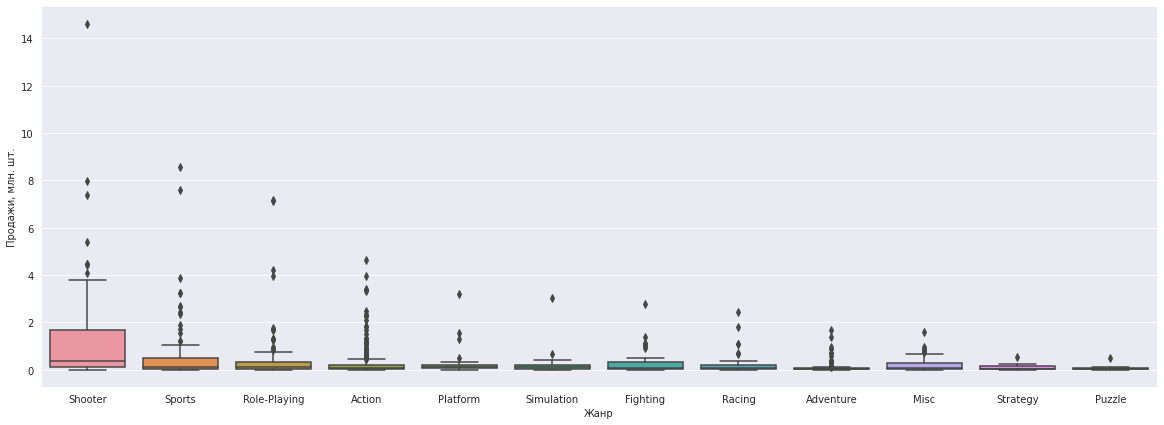

In [40]:
# Построим ящик с усами и посмотрим на распределение
plt.figure(figsize=(20,7))
sns.boxplot(data = analysis_period, x='genre', y='total_sales')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Жанр')

Text(0.5, 0, 'Жанр')

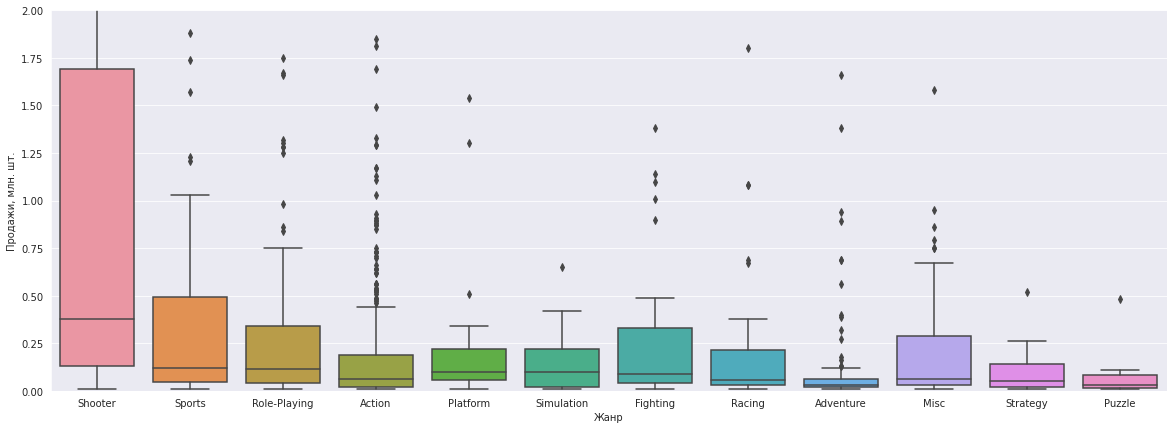

In [41]:
# В данных есть выбросы, ограничим ось у для большей наглядности
plt.figure(figsize=(20,7))
plt.ylim([0,2])
sns.boxplot(data = analysis_period, x='genre', y='total_sales')
plt.ylabel('Продажи, млн. шт.')
plt.xlabel('Жанр')

Наибольшей популярностью пользователей обладают жанры -  `Shooter`, `Sport` и `Role-Playing`, к наименее популярным жанрам можно отнести `adventure` и `puzzle`.

На данном этапе мы:
 - определили актуальный период для анализа
 - выделили самые прибыльные платформы
 - выяснили, что оценка пользователей не влияет на продажи платформ, а оценки критиков влияют на продажи незначительно
 - определили, что самыми прибыльными жанрами являются `Shooter`, `Sport` и `Role-Playing`.

## Портрет пользователя

Определим для пользователей из каждого региона (NA, EU, JP):
 - Самые популярные платформы (топ-5)
 - Самые популярные жанры (топ-5)
 - Рассмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе

### Самые популярные платформы (топ-5)

In [42]:
top_platform = analysis_period.pivot_table(index = 'platform', values = ['na_sales','eu_sales', 'jp_sales'], aggfunc=['sum']).reset_index()
top_platform.columns = ['platform', 'eu_sales','jp_sales','na_sales']
top_platform

,platform,eu_sales,jp_sales,na_sales
0,3DS,7.39,23.55,10.31
1,PC,9.10,0.00,3.72
2,PS3,7.30,4.97,5.66
3,PS4,83.54,12.05,63.86
4,PSP,0.00,0.12,0.00
5,PSV,1.08,8.41,0.54
6,Wii,0.73,0.00,0.49
7,WiiU,6.49,4.12,8.86
8,X360,4.21,0.00,8.05
9,XOne,28.10,0.18,50.30


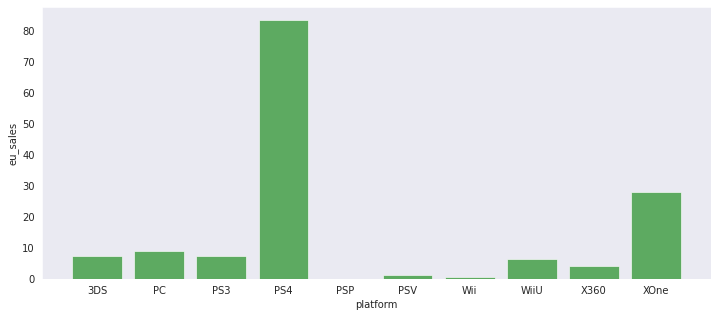

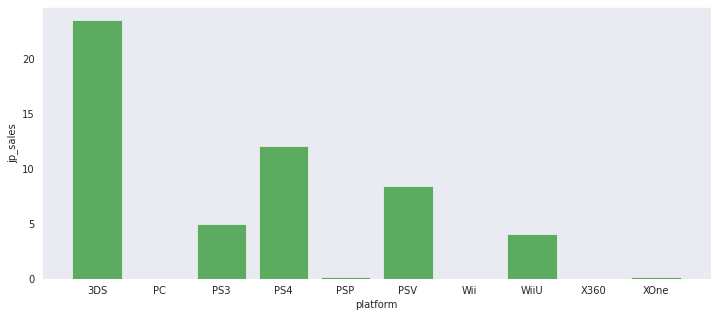

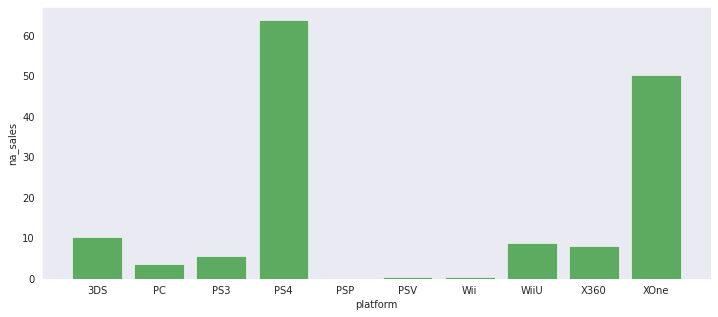

In [43]:
for column in ['eu_sales','jp_sales','na_sales']:
    plt.figure(figsize=(12, 5))
    plt.bar(top_platform['platform'], top_platform[column], color='g', alpha=0.6)

    plt.xlabel('platform')
    plt.ylabel(column)
    plt.grid()
    plt.show()

На графиках видно, что в Европе лидирующую позицию занимает платформа PS4, в Северной Америке 2 лидера - это ХOne и PS4, а в Японии лидирует 3DS, но также неплохие продажи по PS4 и PSV.

### Самые популярные жанры (топ-5)

In [44]:
top_genre = analysis_period.pivot_table(index = 'genre', values = ['na_sales','eu_sales', 'jp_sales'], aggfunc=['sum']).reset_index()
top_genre.columns = ['genre', 'eu_sales','jp_sales','na_sales']
top_genre = top_genre.sort_values(by = 'na_sales', ascending = False).head()
top_genre

,genre,eu_sales,jp_sales,na_sales
8,Shooter,40.28,3.79,48.18
0,Action,34.82,23.05,33.68
10,Sports,27.82,1.65,26.31
7,Role-Playing,17.21,13.41,19.82
3,Misc,4.26,3.19,5.58


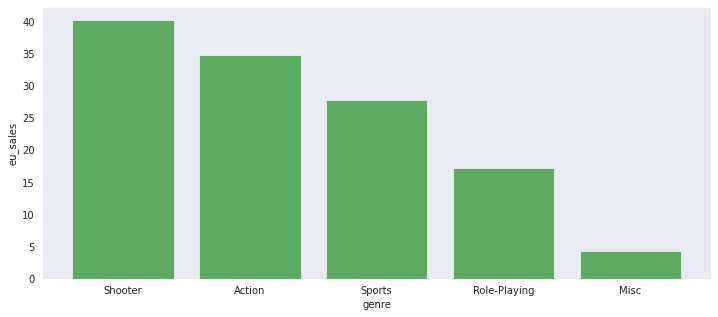

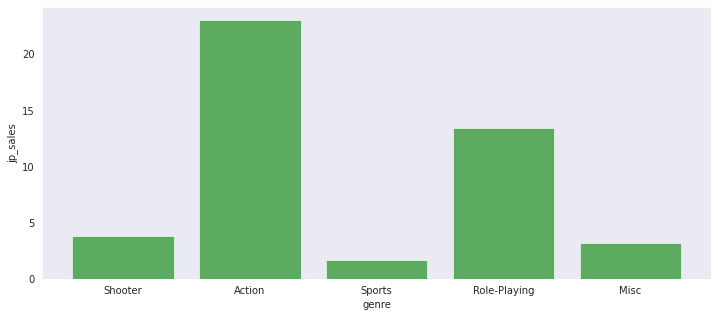

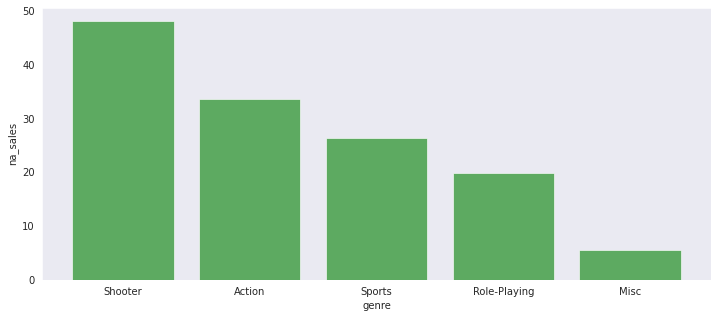

In [45]:
for column in ['eu_sales','jp_sales','na_sales']:
    plt.figure(figsize=(12, 5))
    plt.bar(top_genre['genre'], top_genre[column], color='g', alpha=0.6)

    plt.xlabel('genre')
    plt.ylabel(column)
    plt.grid()
    plt.show()

В Европе и Северной Америке наиболее популярные жанры компьютерных игр - action, shooter и sport, а вот в Японии наряду с action лидирующую позицию занимает жанр role-playing.

### Влияние рейтинга ESRB на продажи

In [46]:
rating = analysis_period.pivot_table(index = 'rating', values = ['na_sales','eu_sales', 'jp_sales'], aggfunc=['sum']).reset_index()
rating.columns = ['rating', 'eu_sales','jp_sales','na_sales']
rating

,rating,eu_sales,jp_sales,na_sales
0,E,34.83,5.25,26.59
1,E10+,11.54,3.27,17.87
2,M,45.54,4.29,47.03
3,T,20.32,7.70,22.86
4,unknown,35.71,32.89,37.44


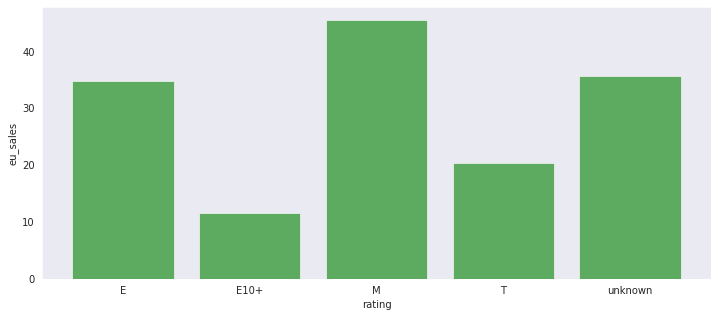

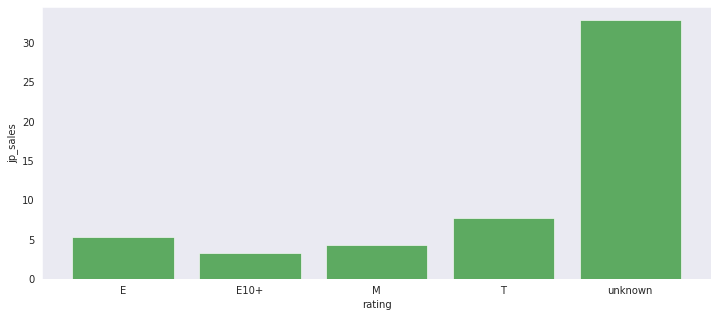

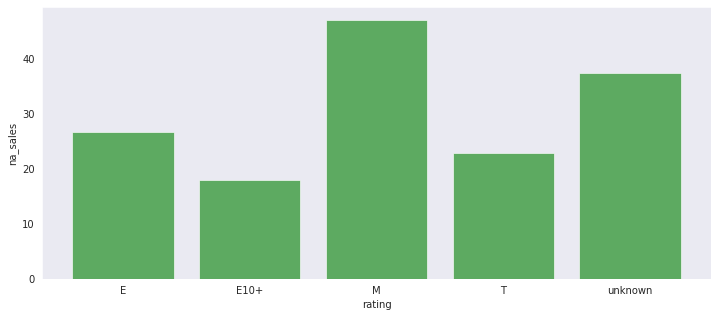

In [47]:
for column in ['eu_sales','jp_sales','na_sales']:
    plt.figure(figsize=(12, 5))
    plt.bar(rating['rating'], rating[column], color='g', alpha=0.6)

    plt.xlabel('rating')
    plt.ylabel(column)
    plt.grid()
    plt.show()

В Европе и Северной Америке наибольшие продажи у игр, которые входят в категорию "Для взрослых" по рейтингу ESRB, в Японии наибольшие продажи у игр, рейтинг по которым не определен, возможно, это связано с тем, что эти игры распространены только в этом регионе и ERSB их не рассматривает.

<div class="alert alert-success"; style="border-left: 7px solid green">
<font size='4'><b>👍 Комментарий ревьюера</b></font>

Здорово, что в начале заменила пропуски на загрушку и не пропустила важную особенность. Скорее всего дело в том, что ESRB предназначен для игр,  выпущенных в США и Канаде, а в Японии, где развит внутренний рынок, есть свои рейтинги
</div>

**Выводы:**

В целом можно сказать, что предпочтения пользователей из Европы и Северной Америки очень схожи, а вот в Японии есть свои особенности:

- в Европе и Северной Америке наиболее популярные платформы - это ХOne и PS4, а в Японии в тройку лидиров входят - 3DS, PS4 и PCV
- наиболее популярные жанры среди европейцев и американцев - action, shooter и sport, а вот японцы не очень любят shooter и sport, предпочитая больше role-playing
- в Европе и Северной Америке наибольшие продажи у игр, которые входят в категорию "Для взрослых" по рейтингу ESRB.

## Проверка гипотез

Проверим следующие гипотезы:
 - Средние пользовательские рейтинги платформ Xbox One и PS3 одинаковые
 - Средние пользовательские рейтинги жанров Action и Sports разные.

### Средние пользовательские рейтинги платформ Xbox One и  PC одинаковые

Сформулируем H0 и Н1:

H0: средние пользовательские рейтинги платформ «Xbox One » и «PC» одинаковые\
H1: средние пользовательские рейтинги платформ «Xbox One » и «PC» различается

Уровень статистической значимости зададим равным 5%

In [48]:
XOne_user_score = df[df['platform'] == "XOne"]['user_score'].dropna()
PС_user_score = df[df['platform'] == "PC"]['user_score'].dropna()

In [49]:
alpha = .05

results = st.ttest_ind(
    XOne_user_score, 
    PС_user_score)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.006207707506247993
Отвергаем нулевую гипотезу


Согласно тесту, мы отвергаем нулевую гипотезу, таким образом, мы можем предполагать, что рейтинги у платформ Xbox One и PC не одинаковые.
</div>

### Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем H0 и Н1:

H0: cредние пользовательские рейтинги жанров Action и Sports одинаковые\
H1: cредние пользовательские рейтинги жанров Action и Sports различается

Уровень статистической значимости зададим равным 5%

In [50]:
action_user_score = df[df['genre']=='Action']['user_score'].dropna()
sports_user_score = df[df['genre']=='Sports']['user_score'].dropna()

In [51]:
alpha = .05

results = st.ttest_ind(
    action_user_score, 
    sports_user_score)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.5138864794224173e-14
Отвергаем нулевую гипотезу


Согласно тесту, мы отвергаем нулевую гипотезу, таким образом, мы можем предполагать, что рейтинги жанров Action и Sports действительно разные.

## Общий вывод

Целью нашего исследования было выявление закономерностей, определяющих успешность игры. 

В первую очередь мы проверили корректность данных: изменили стиль заголовков, обработали пропуски, проверили данные на дубликаты и аномалии, а также дополнительно рассчитали суммарные продажи во всех регионах.

Далее провели исследовательский анализ данных, с помощью которого определили актуальные данные для анализа: период мы ограничили с 2015 по 2016 год и выделили 5 наиболее популярных платформ (PS4, XOne, X360, PS3, 3DS). Также в ходе этого этапа были сделаны следующие выводы:

- оценка пользователей не влияет на продажи платформ, а оценки критиков влияют на продажи незначительно
- самые прибыльные жанры  `Shooter`, `Sport` и `Role-Playing`.
 
Анализ портрета пользователя показал, что предпочтения пользователей в Японии отличаются от предпочтений пользователей в Европе и Северной Америке, а именно:

- в Европе и Северной Америке наиболее популярные платформы - ХOne и PS4, а в Японии в тройку лидиров входят - 3DS, PS4 и PCV
- наиболее популярные жанры среди европейцев и американцев - action, shooter и sport, японцы больше предпочитают action и role-playing
- в Европе и Северной Америке наибольшие продажи у игр, которые входят в категорию "Для взрослых" по рейтингу ESRB.

В ходе анализа мы проверили следующие гипотезы:

 - средние пользовательские рейтинги платформ Xbox One и PС одинаковые - эта гипотеза не подтвердилась
 - средние пользовательские рейтинги жанров Action и Sports разные - эта гипотеза подтвердилась

Таким образом, можно выделить следующие характеристики успешной игры:

- игра должна быть разработана на платформе PS4 или XOne, так как у этих платформ есть потенциал дальнейшего роста продаж
- жанр должен быть `Action`,`Shooter` или `Sport` для европейского или американского рынка и `Action` или `Role-playing` для азиатского рынка
